In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import math
from sklearn.model_selection import train_test_split
import pickle

pd.options.display.float_format = '{:20,.2f}'.format # formatting

## Load Data
Data is given in separate csv files. Append to form 1 main data table. 

In [2]:
## Initial load
# Loading features data 
path = r'../data/features'
all_files = glob.glob(path + "/*.csv")
df = pd.concat(pd.read_csv(f) for f in all_files)

# Loading the labels file
labels = pd.read_csv("../data/labels/part-00000-e9445087-aa0a-433b-a7f6-7f4c19d78ad6-c000.csv")

In [3]:
# ## Subsequent loads
# # load features data ; change file path accordingly
# fpath = "../data/features/sorted.pkl"
# data = pickle.load(open(fpath,'rb'))
# labels = pd.read_csv("../data/labels/cleaned_labels.csv", index_col=0)


### Data Cleaning
Steps taken:
1. Remove **duplicate** bookingIDs from both datasets
2. **Sort** the dataset so we can easily compare consecutive records. 
3.	Remove **Inaccurate records**, and treat them as missing records. Inaccurate i.e.:
    - `second` >= 10000 (Drill down also shows that these high numbers are not continuous with their preceding 'correct' records.) 
    - `Speed` < 0 (physically impossible)
4. Remove **Inaccurate trips**, i.e.:
    - (?) Long trips, with largest known `second` is > 2 hours.  
    - Only some records at the end of the trip which are negative – the rest are correct. (Number of records = `Max(second)`) 
    - Trips where the % of data collected/entire known duration of the trip (highest recorded `second`) is < 50%.
5.	Missing Records **Imputation**
    - ONLY if the missing records are NOT consecutive for more than 5 seconds (?)
    - Some bookingIDs have missing records, including those we have removed earlier for being inaccurate. 
    - We will use rolling window to impute these missing records *only* if the gap between records is not more than 5 seconds. 

#### Remove Duplicates

In [3]:
unique_labels = labels.bookingID.value_counts()
duplicates = labels.loc[labels.bookingID.duplicated(),'bookingID']

print("There are {} unique labels, \
but a total of {} records in the labels dataset. \
This corresponds to {} records in the features dataset.".format(
    len(unique_labels), 
    len(labels), 
    df.loc[df.bookingID.isin(duplicates),'bookingID'].value_counts().sum()))

There are 20000 unique labels, but a total of 20018 records in the labels dataset. This corresponds to 18857 records in the features dataset.


In [4]:
# List of affected bookingIDs
df.loc[df.bookingID.isin(duplicates),'bookingID'].value_counts()

154618822837     2256
1649267441751    1574
1408749273124    1527
515396075694     1289
1511828488211    1245
970662608932     1237
13               1228
1348619731077    1215
455266533495     1182
403726925929     1164
919123001348      975
1391569403991     941
223338299461      656
1279900254294     626
1632087572573     584
481036337234      465
695784702084      363
395136991308      330
Name: bookingID, dtype: int64

In [5]:
# Remove duplicates from both datasets
df_clean = df[~df.bookingID.isin(duplicates)].copy()
labels_clean = labels[~labels.bookingID.isin(duplicates)].copy()

In [6]:
# Check if duplicates still exist in the features dataset
# duplicated_seconds = df_clean[df_clean.duplicated(['bookingID','second'])]
# print(len(duplicated_seconds))

0


In [7]:
# Sort the data for the next step 
df_sorted = df_clean.sort_values(['bookingID','second']).copy()

#### Inaccurate Data
When the `Accuracy` recorded in the features dataset gets too high, we notice that the `Speed` of the row can become -1, or the recorded `Second` can become extremely large. This is likely due to the GPS on the phone losing connectivity(e.g. due to car being in tunnels). Such records should be removed first. We will later impute this with the other missing records.

In [39]:
# negative_records = df_sorted[df_sorted.Speed < 0]
# print('{} records have speed < 0, which is {:.2}% of df_sorted'.format(len(negative_records), len(negative_records) / len(df_sorted) * 100))
# print('These belong to {} unique booking IDs'.format(len(negative_records.bookingID.unique())))
# df_sorted[(df_sorted.Speed < 0) & (df_sorted.Accuracy > 20)].head(10)

240053 records have speed < 0, which is 1.5% of df_sorted
These belong to 8650 unique booking IDs


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
1519100,0,48.00,283.08,-3.17,-9.61,1.04,-0.07,0.05,-0.08,"1,200.00",-1.00
774049,26,24.50,0.00,-0.41,10.02,-0.64,0.04,0.06,-0.13,405.00,-1.00
618524,28,600.00,0.00,0.07,8.94,0.93,-0.12,-0.05,0.05,689.00,-1.00
840745,28,759.36,0.00,-0.55,10.52,-1.37,0.11,0.06,-0.05,736.00,-1.00
557125,28,"1,027.03",0.00,0.75,9.98,1.06,0.05,-0.04,-0.01,782.00,-1.00
1551418,28,"1,375.98",0.00,-0.43,9.78,2.06,0.02,0.03,-0.04,826.00,-1.00
572076,39,45.77,0.00,-0.32,5.70,1.75,-0.40,0.08,0.01,597.00,-1.00
1157729,47,41.71,0.00,0.95,5.46,7.98,0.00,-0.11,-0.21,0.00,-1.00
61080,47,41.71,0.00,-0.29,5.43,7.25,-0.02,0.01,0.05,40.00,-1.00
877738,47,25.61,0.00,0.24,6.89,8.25,0.04,0.04,0.02,60.00,-1.00


In [16]:
# df_nonegative = df_sorted[df_sorted.Speed >= 0].copy()
# len(df_nonegative)

15876651

#### Remove Impossible records - Seconds

In [8]:
# Test by skipping the removal of negatives
df_nonegative = df_sorted.copy()

In [9]:
# Let's check the seconds column for records with excessively long 'known duration'
df_nonegative.groupby('bookingID').agg('max').sort_values(by='second', ascending=False).head(10)

,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
bookingID,,,,,,,,,,
1503238553722,44.10,359.00,3.92,12.80,0.48,0.30,0.31,0.14,"1,495,796,757.00",19.44
1460288880770,9.39,359.00,3.68,12.41,3.52,1.29,2.69,0.75,"619,316,568.00",26.95
858993459333,49.49,358.00,2.85,11.58,15.85,0.19,0.50,0.24,"619,315,993.00",21.06
1434519076976,32.38,359.00,4.02,14.02,10.19,0.95,6.11,0.57,"619,315,595.00",25.15
1108101562401,13.42,359.00,2.60,10.89,8.15,0.52,0.96,0.47,"619,315,523.00",18.17
438086664371,35.60,359.00,18.22,29.35,19.09,5.34,9.01,5.50,"8,235.00",20.43
532575944853,9.32,356.00,3.62,11.52,7.35,0.35,0.56,0.24,"7,355.00",16.00
446676598869,22.60,359.00,2.31,11.56,5.89,0.38,1.58,0.75,"5,988.00",27.29
1374389534819,"2,000.00",359.85,4.05,-4.26,3.71,1.63,1.19,0.54,"4,499.00",25.53


We may want to exclude trips that took longer than 2 hours, since it is rare that trips in Singapore would last for so long. However, the longest record is suspiciously high, let's take a closer look.

In [18]:
# Drill Down: 
df_nonegative[df_nonegative.bookingID==1503238553722].tail(10)

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
156556,1503238553722,3.90,325.00,0.78,8.66,-2.20,0.01,-0.00,0.02,396.00,18.41
903053,1503238553722,3.90,325.00,1.83,8.57,-0.79,-0.01,-0.02,0.00,397.00,18.24
744706,1503238553722,3.90,325.00,0.94,8.47,-1.83,-0.03,-0.00,0.00,398.00,18.19
1212988,1503238553722,3.90,326.00,0.19,9.35,-2.39,-0.00,-0.00,-0.01,399.00,18.39
787523,1503238553722,3.90,326.00,0.18,9.09,-1.99,-0.00,0.00,-0.00,400.00,18.58
484514,1503238553722,3.90,326.00,0.46,10.00,-2.19,0.01,0.00,0.00,401.00,18.77
332034,1503238553722,3.90,326.00,0.48,10.04,-2.18,-0.00,0.01,-0.00,402.00,18.83
10303,1503238553722,3.22,325.00,-0.06,9.65,-2.10,-0.01,0.01,0.02,403.00,19.16
1299210,1503238553722,3.90,324.00,0.17,10.08,-1.96,-0.00,0.02,0.02,404.00,19.44
1084533,1503238553722,30.64,0.00,0.33,9.64,-1.97,-0.01,0.01,0.00,"1,495,796,757.00",0.00


We should remove just this record, and keep the rest of the trip, which seem to have acceptable values. <br>
Repeated this step for the other 2 records than took > 2 hours, and found that the trips were actually that long. Will not remove.

In [19]:
df_cleanSecond = df_nonegative[df_nonegative.second<=10000].reset_index(drop=True).copy()

#### Remove Inaccurate Trips
Trips which have most of the data missing

In [20]:
# find % missing, i.e. % of count over maximum second of each trip 
features_agg = df_cleanSecond.groupby('bookingID')['second'].agg(['min','max','count'])
# features_agg['perc_max'] = features_agg['count'] / (features_agg['max'] + 1)
features_agg['perc_available'] = features_agg['count'] / (features_agg['max'] - features_agg['min'] + 1)

print('max value of max')
print(max(features_agg['max']))
print('max value of count')
print(max(features_agg['count']))

max value of max
8235.0
max value of count
7561


In [21]:
# Trips reportedly lasting more than an hour 
features_agg[features_agg['max'] > 3600]

,min,max,count,perc_available
bookingID,,,,
34359738469,0.00,"4,305.00",4302,1.00
60129542174,0.00,"3,688.00",434,0.12
438086664371,0.00,"8,235.00",7561,0.92
446676598842,0.00,"3,614.00",259,0.07
446676598869,0.00,"5,988.00",542,0.09
532575944853,0.00,"7,355.00",135,0.02
747324309632,0.00,"3,689.00",3674,1.00
833223655429,0.00,"3,928.00",2696,0.69
893353197656,0.00,"4,064.00",3486,0.86


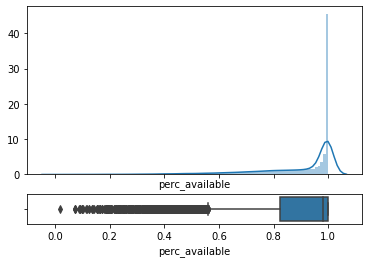

In [22]:
f, (ax_box, ax_hist) = plt.subplots(2,sharex=True, gridspec_kw={"height_ratios":(.85,.15)})
sns.boxplot(features_agg['perc_available'], ax=ax_hist)
sns.distplot(features_agg['perc_available'], bins=100, ax=ax_box)

In [23]:
perc_check = 0.5
print("There are only {} records with more than {}% of the trips missing.".format(len(features_agg[features_agg['perc_available']<perc_check]), (1-perc_check)*100))

There are only 781 records with more than 50.0% of the trips missing.


In [35]:
high_perc_missing = features_agg[features_agg.perc_available < perc_check].index
# high_perc_missing[:10]

In [40]:
df_removed50perc = df_cleanSecond[~df_cleanSecond.bookingID.isin(high_perc_missing)].copy()
labels_removed50perc = labels_clean[~labels_clean.bookingID.isin(high_perc_missing)]

In [45]:
print(len(df_cleanSecond) - len(df_removed50perc), "records removed because missing >50% of the trip.")
# We may or may not use this removed50perc.

273165 records removed because missing >50% of the trip.


In [37]:
df_removed50perc.head()

,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
0,0,12.00,143.30,0.82,-9.94,-2.01,-0.02,-0.09,0.07,0.00,3.44
1,0,8.00,143.30,0.55,-9.84,-2.04,-0.05,-0.08,0.04,1.00,0.23
2,0,8.00,143.30,-1.71,-9.27,-1.21,-0.03,-0.03,0.02,2.00,0.23
3,0,8.00,143.30,-1.42,-9.55,-1.86,-0.02,0.01,-0.03,3.00,0.23
4,0,8.00,143.30,-0.60,-9.85,-1.38,-0.01,-0.05,0.02,4.00,0.23


##### Visualizing Missing Data
For a single booking ID, we can visualize which part of their trip has missing data.

23690                  94.00
23691                  95.00
23692                  98.00
23693                  99.00
23694                 100.00
Name: second, dtype: float64


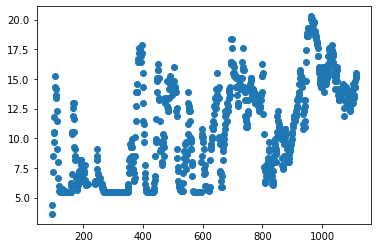

In [304]:
id = 47
print(df_cleanSecond[df_cleanSecond.bookingID == id].second.head())
plt.scatter(df_cleanSecond[df_cleanSecond.bookingID == id].second,
#             np.arange(0,len(df_cleanSecond[df_cleanSecond.bookingID == id])) # plot by the expected consecutive range of seconds
            df_cleanSecond[df_cleanSecond.bookingID == id].Speed 
           )
ls = list(df_cleanSecond[df_cleanSecond.bookingID == id].second.astype('int'))
# print(len(missing_elements(ls)))

# Cleaning missing records in a reasonable trip
1. Cut-off point for data with % missing that we cannot accept.
    - For now: 50%, the 25th percentile for the missing data. This removes 813 records only. 
    - If we reduce to 75% threshold, we will only remove 88 records.
    - By remove, I mean to remove the entire trip.
2. For each bookingID, find whether the missing records are consecutive or dispersed. 
    - If dispersed (e.g. phone only records telematics data every 5 seconds), we might be able to impute if the interval is small. 
    - If it's consecutive, go to next step
3. For chunks of missing data, find out whether the remaining data has enough value for our purposes
    - If it's one big chunk, do we still want to keep information about the other sections of the trip? (see plot about visualizing missing data below)
    - If it's several small chunks, can we get enough information out of the trip? 

Note the limitation here is that we do not know for sure whether the last known 'second' of the trip is truly the last - what if the driver ended the trip but continued to send the passenger elsewhere? I don't think this is important, but perhaps should note as an assumption.

In [271]:
## Another way to find the differences by row
# df_removed50perc[df_removed50perc.second.diff() > 5]

In [24]:
def missing_elements(L):
    """
    Finds the missing elements given a list L. 
    """
    start, end = L[0], L[-1]
    return sorted(set(range(start, end + 1)).difference(L))

from itertools import groupby
from operator import itemgetter
def getConsecMissingLength(ls, length_only=True):
    """
    Input: list of integers 
        length_only (default True) to return only the length of consecutive missing
    Output: list of consecutive missing numbers (length_only=False) 
        OR list of length of each consecutive missing (length_only=True; default)
    """    
    results = []
    for k, g in groupby(enumerate(ls), lambda ix : ix[0] - ix[1]):
        if length_only:
            results.append(len(list(map(itemgetter(1),g))))
        else:
            results.append(list(map(itemgetter(1), g)))
    return results

To identify bookingIDs which we are uncomfortable with imputing:
First we need to define the unacceptable range for consecutive missing: 
- If the number of missing values is > 5 
- and if the number of missing values is within +-5 of the range of missing values

In [26]:
# threshold for consecutive missing numbers. anything >= this window this too much to impute. 
window = 5 

In [47]:
# Creating a dataframe to look specifically at the seconds data
df_t = df_cleanSecond.copy()
df_t['second'] = df_t['second'].astype('int')
df_s = pd.DataFrame(df_t.groupby('bookingID')['second'].apply(list))

# Creating columns
df_s['missing'] = df_s['second'].apply(missing_elements)
df_s['missingCount'] = df_s['missing'].str.len()
df_s['missingRange'] = (df_s['missing'].str[-1] - df_s['missing'].str[0])
df_s['missingNumbersDelta'] = df_s['missing'].apply(getConsecMissingLength)

# Reducing the size of the dataframe to only those with 5 or more missing values.
df_m = df_s[df_s.missingCount >= window]
df_m['MaxDelta'] = list(map(max, df_m['missingNumbersDelta'])) # get the maximum of the Delta

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [29]:
df_s.head(10)

,second,missing,missingCount,missingRange,missingNumbersDelta
bookingID,,,,,
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[315, 316, 317, 318, 319, 320, 321, 322, 323, ...",586,704.00,"[585, 1]"
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[120, 121, 122, 123, 124, 125, 126, 127, 128, ...",184,748.00,"[180, 1, 1, 1, 1]"
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[120, 121, 122, 123, 124, 125, 126, 127, 128, ...",631,679.00,"[630, 1]"
4,"[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14...",[5],1,0.00,[1]
6,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],0,nan,[]
7,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...","[11, 28, 30, 37, 235, 360, 409, 587, 705, 707,...",11,781.00,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]"
8,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[39, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7...",76,305.00,"[1, 73, 1, 1]"
10,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...",[],0,nan,[]
11,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[165, 166, 167, 168, 169, 170, 171, 172, 173, ...",75,74.00,[75]


In [30]:
df_m.head(20)

,second,missing,missingCount,missingRange,missingNumbersDelta,MaxDelta
bookingID,,,,,,
0,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[315, 316, 317, 318, 319, 320, 321, 322, 323, ...",586,704.00,"[585, 1]",585
1,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[120, 121, 122, 123, 124, 125, 126, 127, 128, ...",184,748.00,"[180, 1, 1, 1, 1]",180
2,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[120, 121, 122, 123, 124, 125, 126, 127, 128, ...",631,679.00,"[630, 1]",630
7,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14,...","[11, 28, 30, 37, 235, 360, 409, 587, 705, 707,...",11,781.00,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]",1
8,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[39, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 7...",76,305.00,"[1, 73, 1, 1]",73
11,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[165, 166, 167, 168, 169, 170, 171, 172, 173, ...",75,74.00,[75],75
16,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[36, 76, 135, 203, 364, 486, 528, 588, 628]",9,592.00,"[1, 1, 1, 1, 1, 1, 1, 1, 1]",1
17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[507, 508, 509, 510, 511, 512, 517, 518, 519]",9,12.00,"[6, 3]",6
25,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[150, 151, 152, 153, 154, 155, 156, 157, 158, ...",375,374.00,[375],375


In [53]:
print("""
Out of {} bookingIDs after first round of cleaning:
{} bookingIDs have no missing values.
{} bookingIDs have missing values < 5 missing values (can be imputed).

Out of the remaining {} bookingIDs with 5 or more missing values, 
{} have 5 or more consecutive missing values that cannot be reliably imputed (should be removed).
""".format(len(df_s), 
           len(df_s[df_s.missingCount == 0]),
           len(df_s[(df_s.missingCount < window) & (df_s.missingCount > 0)]),
           len(df_m),
           len(df_m[df_m.MaxDelta>=window])
          ))


Out of 19982 bookingIDs after first round of cleaning:
4968 bookingIDs have no missing values.
3245 bookingIDs have missing values < 5 missing values (can be imputed).

Out of the remaining 11769 bookingIDs with 5 or more missing values, 
8973 have 5 or more consecutive missing values that cannot be reliably imputed (should be removed).



In [ ]:
### 

In [32]:
# get the bookingIDs 
to_impute = df_s[df_s.missingCount < window].index
to_impute = to_impute.append(df_m[df_m.MaxDelta < window].index)
to_remove = df_m[df_m.MaxDelta >= window].index

# print(len(to_impute), len(to_remove)) # checking

In [34]:
# removing bookingIDs with too much consecutive missing information 
# df_clean_final = df_removed50perc[~df_removed50perc.bookingID.isin(to_remove)]
# labels_clean_final = labels_removed50perc[~labels_removed50perc.bookingID.isin(to_remove)]
print(len(df_clean_final))
df_clean_final.head()

8487327


,bookingID,Accuracy,Bearing,acceleration_x,acceleration_y,acceleration_z,gyro_x,gyro_y,gyro_z,second,Speed
2050,4,10.00,57.71,-0.69,-9.18,-3.63,-0.02,0.11,-0.09,0.00,7.99
2051,4,10.00,57.71,-0.58,-8.91,-3.19,-0.03,0.01,0.00,1.00,5.17
2052,4,10.00,57.71,-0.59,-9.35,-2.68,0.01,0.08,-0.03,2.00,4.09
2053,4,10.00,57.71,-0.48,-9.21,-3.37,-0.01,0.01,0.05,3.00,3.72
2054,4,10.00,57.71,-0.32,-9.19,-3.18,-0.03,0.07,-0.03,4.00,3.72


In [244]:
len(df_clean_final.bookingID.unique())

10477

After removing ruthlessly, only left with 7.8million records of 10477 bookingIDs. About half of the initial. Should probably relax the criteria. But at least now we have a framework for cleaning.

#### Impute Missing Data
Fill gaps in second column with nan. Fillna with `.rolling()` and `mean()`.

In [248]:
# df_clean_final[df_clean_final.bookingID.isin(to_impute)].head(20)
df_backup = df_clean_final.copy()

In [276]:
trips_knownrange = pd.DataFrame(df_clean_final.groupby('bookingID')['second'].agg(['min','max']))

In [ ]:

# Fill missing rows with nans

# fillnans with rolling mean.

In [ ]:
# create multi-index
df_clean_final.set_index(['bookingID','second'])
# f = lambda df_clean_final: df_clean_final.resample(rule='s', how='first')
# df_clean_final.reset_index(level=0).groupby('bookingID').apply(f)

In [346]:
df_clean_final.set_index('bookingID').second.to_frame().groupby('bookingID')['second'].head()

bookingID
4                               0.00
4                               1.00
4                               2.00
4                               3.00
4                               4.00
                        ...         
1709396983971                   0.00
1709396983971                   1.00
1709396983971                   2.00
1709396983971                   3.00
1709396983971                   4.00
Name: second, Length: 52379, dtype: float64

In [351]:
df_clean_final.loc[:,['bookingID','second']].set_index()

,bookingID,second
2036,4,0.00
2037,4,1.00
2038,4,2.00
2039,4,3.00
2040,4,4.00
2041,4,6.00
2042,4,7.00
2043,4,8.00
2044,4,9.00
2045,4,10.00


In [357]:
test_index = df_clean_final.set_index('bookingID').second.to_frame().groupby('bookingID')['second'].apply(lambda x: pd.Series(1,index=range(int(x.min()), int(x.max()))).index)
test_index

bookingID
4                RangeIndex(start=0, stop=1094, step=1)
6                RangeIndex(start=0, stop=1094, step=1)
7                 RangeIndex(start=0, stop=959, step=1)
10                RangeIndex(start=0, stop=374, step=1)
14                RangeIndex(start=0, stop=599, step=1)
                                  ...                  
1709396983906     RangeIndex(start=0, stop=465, step=1)
1709396983933    RangeIndex(start=0, stop=2849, step=1)
1709396983941     RangeIndex(start=0, stop=569, step=1)
1709396983948     RangeIndex(start=0, stop=257, step=1)
1709396983971    RangeIndex(start=0, stop=1079, step=1)
Name: second, Length: 10477, dtype: object

In [359]:
### Need to figure out this reindexing part.
df_clean_final.set_index(['bookingID','second']).reindex(test_index)

In [360]:
## Possible alternative way to reset the index
# df_filled = df_clean_final.set_index(['bookingID','second']).reindex(['second']).rename_axis('sec').reset_index()
# data.set_index('Date').reindex(r).rename_axis('Date').reset_index()

## Save the cleaned data

In [54]:
df_cleanSecond.to_pickle('../data/features/data_neverRemove.pkl')
# labels_clean_final.to_csv("../data/labels/cleaned_labels.csv", index = False)